# Big Data Analytics Project
### Implemented by Umberto Altieri

**The implementation of this project involves exploring data-mining techniques for an online retailer using the pyspark library, following in part the paper related to the dataset (https://www.researchgate.net/publication/346668481_Machine_Learning_Supervised_Analysis_for_Enhancing_Incident_Management_Process). The approach applied in this study involves a classification/regression and clustering methods. Each attribute is individually analyzed based on its relevance in the possible decision-making capabilities of human experts. **

#**Imports**

#**Download of the dataset**

In [1]:
!wget https://archive.ics.uci.edu/static/public/498/incident+management+process+enriched+event+log.zip

--2024-02-02 21:28:33--  https://archive.ics.uci.edu/static/public/498/incident+management+process+enriched+event+log.zip
Resolving archive.ics.uci.edu (archive.ics.uci.edu)... 128.195.10.252
Connecting to archive.ics.uci.edu (archive.ics.uci.edu)|128.195.10.252|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified
Saving to: ‘incident+management+process+enriched+event+log.zip’

incident+management     [  <=>               ]   2.29M  6.85MB/s    in 0.3s    

2024-02-02 21:28:33 (6.85 MB/s) - ‘incident+management+process+enriched+event+log.zip’ saved [2400214]



In [2]:
!unzip /content/incident+management+process+enriched+event+log.zip

Archive:  /content/incident+management+process+enriched+event+log.zip
  inflating: incident_event_log.csv  


In [3]:
try:
    import pyspark
except ModuleNotFoundError:
    print("Pyspark not found. Installing quietly")
    !pip install pyspark -q

Pyspark not found. Installing quietly
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 316.9/316.9 MB 2.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done


In [4]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from zipfile import ZipFile
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, date_format, datediff, current_date, max, count, sum
from pyspark.ml.feature import RFormula, StandardScaler
from pyspark.ml.clustering import KMeans
from pyspark.ml.classification import DecisionTreeClassifier, RandomForestClassifier
from pyspark.ml.evaluation import ClusteringEvaluator, MulticlassClassificationEvaluator, BinaryClassificationEvaluator
from pyspark.ml.evaluation import RegressionEvaluator
import seaborn as sns
from pyspark.ml.regression import LinearRegression, RandomForestRegressor, DecisionTreeRegressor, GBTRegressor
from pyspark.ml.feature import PCA, VectorAssembler
from pyspark.sql.functions import col, datediff, to_date, from_unixtime, unix_timestamp, expr


seed = 42   # set the random seed

In [5]:

spark = SparkSession.builder.getOrCreate()
spark

In [6]:
df = spark.read.csv("/content/incident_event_log.csv",sep=',', header=True, inferSchema=True)


#Data exploration

In [7]:
df.show()

+----------+------------------+------+------------------+------------+-------------+--------+-----------+--------------+---------------+--------------+---------------+--------------+---------------+------------+------------+-----------+---------------+-----------+-------+----------+----------+------------+----------------+-----------+---------+-----------------------+-------------+-------------+---+------+---------+-----------+---------------+---------------+--------------+
|    number|    incident_state|active|reassignment_count|reopen_count|sys_mod_count|made_sla|  caller_id|     opened_by|      opened_at|sys_created_by| sys_created_at|sys_updated_by| sys_updated_at|contact_type|    location|   category|    subcategory|  u_symptom|cmdb_ci|    impact|   urgency|    priority|assignment_group|assigned_to|knowledge|u_priority_confirmation|       notify|   problem_id|rfc|vendor|caused_by|closed_code|    resolved_by|    resolved_at|     closed_at|
+----------+------------------+------+----

Format the values inside the dataframe because it contains strings not meaningful

In [8]:


df = df.withColumn("caller_id", expr("replace(caller_id, 'Caller ', '')"))
df = df.withColumn("opened_by", expr("replace(opened_by, 'Opened by ', '')"))
df = df.withColumn("opened_at", expr("split(opened_at, ' ')[0]"))
df = df.withColumn("sys_updated_by", expr("split(sys_updated_by, ' ')[0]"))
df = df.withColumn("sys_updated_at", expr("split(sys_updated_at, ' ')[0]"))
df = df.withColumn("sys_created_by", expr("split(sys_created_by, ' ')[0]"))
df = df.withColumn("sys_created_at", expr("split(sys_created_at, ' ')[0]"))
df = df.withColumn("location", expr("replace(location, 'Location ', '')"))
df = df.withColumn("category", expr("replace(category, 'Category ', '')"))
df = df.withColumn("subcategory", expr("replace(subcategory, 'Subcategory ', '')"))
df = df.withColumn("u_symptom", expr("replace(u_symptom, 'Symptom ', '')"))
df = df.withColumn("impact", expr("split(impact, ' -')[0]"))
df = df.withColumn("urgency", expr("split(urgency, ' -')[0]"))
df = df.withColumn("priority", expr("split(priority, ' -')[0]"))
df = df.withColumn("assignment_group", expr("replace(assignment_group, 'Group ', '')"))
df = df.withColumn("assigned_to", expr("replace(assigned_to, 'Resolver ', '')"))
df = df.withColumn("problem_id", expr("replace(problem_id, 'Problem ID ', '')"))
df = df.withColumn("resolved_by", expr("replace(resolved_by, 'Resolved by ', '')"))
df = df.withColumn("resolved_at", expr("split(resolved_at, ' ')[0]"))
df = df.withColumn("closed_at", expr("split(closed_at, ' ')[0]"))
df = df.withColumn("closed_code", expr("replace(closed_code, 'code ', '')"))

df.show()


+----------+------------------+------+------------------+------------+-------------+--------+---------+---------+---------+--------------+--------------+--------------+--------------+------------+--------+--------+-----------+---------+-------+------+-------+--------+----------------+-----------+---------+-----------------------+-------------+----------+---+------+---------+-----------+-----------+-----------+---------+
|    number|    incident_state|active|reassignment_count|reopen_count|sys_mod_count|made_sla|caller_id|opened_by|opened_at|sys_created_by|sys_created_at|sys_updated_by|sys_updated_at|contact_type|location|category|subcategory|u_symptom|cmdb_ci|impact|urgency|priority|assignment_group|assigned_to|knowledge|u_priority_confirmation|       notify|problem_id|rfc|vendor|caused_by|closed_code|resolved_by|resolved_at|closed_at|
+----------+------------------+------+------------------+------------+-------------+--------+---------+---------+---------+--------------+--------------

Select and delete columns with more than 10%of occurrences contains '?' values

In [9]:


columns_to_drop=[]
for col_name in df.columns:
    count = df.filter(df[col_name] == '?').count()
    print(f"Column '{col_name}' has {count} occurrences of '?' value.")
    if count>14000:
      columns_to_drop.append(col_name)


Column 'number' has 0 occurrences of '?' value.
Column 'incident_state' has 0 occurrences of '?' value.
Column 'active' has 0 occurrences of '?' value.
Column 'reassignment_count' has 0 occurrences of '?' value.
Column 'reopen_count' has 0 occurrences of '?' value.
Column 'sys_mod_count' has 0 occurrences of '?' value.
Column 'made_sla' has 0 occurrences of '?' value.
Column 'caller_id' has 29 occurrences of '?' value.
Column 'opened_by' has 4835 occurrences of '?' value.
Column 'opened_at' has 0 occurrences of '?' value.
Column 'sys_created_by' has 53076 occurrences of '?' value.
Column 'sys_created_at' has 53076 occurrences of '?' value.
Column 'sys_updated_by' has 0 occurrences of '?' value.
Column 'sys_updated_at' has 0 occurrences of '?' value.
Column 'contact_type' has 0 occurrences of '?' value.
Column 'location' has 76 occurrences of '?' value.
Column 'category' has 78 occurrences of '?' value.
Column 'subcategory' has 111 occurrences of '?' value.
Column 'u_symptom' has 32964 

Columns to be dropped with high density of '?' values by looking at the occurrences printed in the previous print

In [10]:
columns_to_drop

['sys_created_by',
 'sys_created_at',
 'u_symptom',
 'cmdb_ci',
 'assignment_group',
 'assigned_to',
 'problem_id',
 'rfc',
 'vendor',
 'caused_by']

In [11]:

df = df.drop(*columns_to_drop)
df.show()

+----------+------------------+------+------------------+------------+-------------+--------+---------+---------+---------+--------------+--------------+------------+--------+--------+-----------+------+-------+--------+---------+-----------------------+-------------+-----------+-----------+-----------+---------+
|    number|    incident_state|active|reassignment_count|reopen_count|sys_mod_count|made_sla|caller_id|opened_by|opened_at|sys_updated_by|sys_updated_at|contact_type|location|category|subcategory|impact|urgency|priority|knowledge|u_priority_confirmation|       notify|closed_code|resolved_by|resolved_at|closed_at|
+----------+------------------+------+------------------+------------+-------------+--------+---------+---------+---------+--------------+--------------+------------+--------+--------+-----------+------+-------+--------+---------+-----------------------+-------------+-----------+-----------+-----------+---------+
|INC0000045|               New|  true|                 

Results of deleting the columns with high density of '?' values

In [12]:
print('Number of features: ', len(df.columns))
print('Number of instances:', df.count())

Number of features:  26
Number of instances: 141712


In [13]:
df.show()

+----------+------------------+------+------------------+------------+-------------+--------+---------+---------+---------+--------------+--------------+------------+--------+--------+-----------+------+-------+--------+---------+-----------------------+-------------+-----------+-----------+-----------+---------+
|    number|    incident_state|active|reassignment_count|reopen_count|sys_mod_count|made_sla|caller_id|opened_by|opened_at|sys_updated_by|sys_updated_at|contact_type|location|category|subcategory|impact|urgency|priority|knowledge|u_priority_confirmation|       notify|closed_code|resolved_by|resolved_at|closed_at|
+----------+------------------+------+------------------+------------+-------------+--------+---------+---------+---------+--------------+--------------+------------+--------+--------+-----------+------+-------+--------+---------+-----------------------+-------------+-----------+-----------+-----------+---------+
|INC0000045|               New|  true|                 

Select and delete rows with values '?'

In [14]:
list_cols=df.columns
for name_col in list_cols:
  count_rows = df.filter(col(name_col) == '?').count()

  print(f"The number of rows where ",name_col," has the value '?' is: ",count_rows)


The number of rows where  number  has the value '?' is:  0
The number of rows where  incident_state  has the value '?' is:  0
The number of rows where  active  has the value '?' is:  0
The number of rows where  reassignment_count  has the value '?' is:  0
The number of rows where  reopen_count  has the value '?' is:  0
The number of rows where  sys_mod_count  has the value '?' is:  0
The number of rows where  made_sla  has the value '?' is:  0
The number of rows where  caller_id  has the value '?' is:  29
The number of rows where  opened_by  has the value '?' is:  4835
The number of rows where  opened_at  has the value '?' is:  0
The number of rows where  sys_updated_by  has the value '?' is:  0
The number of rows where  sys_updated_at  has the value '?' is:  0
The number of rows where  contact_type  has the value '?' is:  0
The number of rows where  location  has the value '?' is:  76
The number of rows where  category  has the value '?' is:  78
The number of rows where  subcategory  

Delete rows with values of '?'

In [15]:
df = df.filter(df['caller_id' ] != '?')
df = df.filter(df['opened_by' ] != '?')
df = df.filter(df['location' ] != '?')
df = df.filter(df['category' ] != '?')
df = df.filter(df['subcategory' ] != '?')
df = df.filter(df['closed_code' ] != '?')
df = df.filter(df['resolved_by' ] != '?')
df = df.filter(df['resolved_at' ] != '?')


In [16]:
df.show()

+----------+------------------+------+------------------+------------+-------------+--------+---------+---------+---------+--------------+--------------+------------+--------+--------+-----------+------+-------+--------+---------+-----------------------+-------------+-----------+-----------+-----------+---------+
|    number|    incident_state|active|reassignment_count|reopen_count|sys_mod_count|made_sla|caller_id|opened_by|opened_at|sys_updated_by|sys_updated_at|contact_type|location|category|subcategory|impact|urgency|priority|knowledge|u_priority_confirmation|       notify|closed_code|resolved_by|resolved_at|closed_at|
+----------+------------------+------+------------------+------------+-------------+--------+---------+---------+---------+--------------+--------------+------------+--------+--------+-----------+------+-------+--------+---------+-----------------------+-------------+-----------+-----------+-----------+---------+
|INC0000045|               New|  true|                 

#Schema

In [17]:
df.printSchema()

root
 |-- number: string (nullable = true)
 |-- incident_state: string (nullable = true)
 |-- active: boolean (nullable = true)
 |-- reassignment_count: integer (nullable = true)
 |-- reopen_count: integer (nullable = true)
 |-- sys_mod_count: integer (nullable = true)
 |-- made_sla: boolean (nullable = true)
 |-- caller_id: string (nullable = true)
 |-- opened_by: string (nullable = true)
 |-- opened_at: string (nullable = true)
 |-- sys_updated_by: string (nullable = true)
 |-- sys_updated_at: string (nullable = true)
 |-- contact_type: string (nullable = true)
 |-- location: string (nullable = true)
 |-- category: string (nullable = true)
 |-- subcategory: string (nullable = true)
 |-- impact: string (nullable = true)
 |-- urgency: string (nullable = true)
 |-- priority: string (nullable = true)
 |-- knowledge: boolean (nullable = true)
 |-- u_priority_confirmation: boolean (nullable = true)
 |-- notify: string (nullable = true)
 |-- closed_code: string (nullable = true)
 |-- resolv

In [18]:
df.columns

['number',
 'incident_state',
 'active',
 'reassignment_count',
 'reopen_count',
 'sys_mod_count',
 'made_sla',
 'caller_id',
 'opened_by',
 'opened_at',
 'sys_updated_by',
 'sys_updated_at',
 'contact_type',
 'location',
 'category',
 'subcategory',
 'impact',
 'urgency',
 'priority',
 'knowledge',
 'u_priority_confirmation',
 'notify',
 'closed_code',
 'resolved_by',
 'resolved_at',
 'closed_at']

Modification on columns including summarization

#Features explanation

In [19]:

'''
list_cols=[
  'number', #ID
 'incident_state', #eight levels controlling the incident management process transitions from opening until closing the case;
 'active',#boolean attribute that shows whether the record is active or closed/canceled;
 'reassignment_count', #number of times the incident has the group or the support analysts changed; #---------------------------summarized
 'reopen_count', #number of times the incident resolution was rejected by the caller; #---------------------------summarized
 'sys_mod_count', #number of incident updates until that moment;
 'made_sla', # boolean attribute that shows whether the incident exceeded the target SLA;
 'caller_id', #identifier of the user affected;   #---------------------------summarized
 'opened_by', # identifier of the user who reported the incident; #---------------------------summarized
 'opened_at', #incident user opening date and time; #---------------------------summarized
 'sys_updated_by', #identifier of the user who registered the incident; #---------------------------summarized
 'sys_updated_at', # incident system creation date and time; #optional
 'contact_type', #categorical attribute that shows by what means the incident was reported; #optional
 'location', # identifier of the location of the place affected;
 'category', #first-level description of the affected service;
 'subcategory', #second-level description of the affected service (related to the first level description, i.e., to category);
 'impact', #description of the impact caused by the incident (values: 1â€“High; 2â€“Medium; 3â€“Low);
 'urgency', # description of the urgency informed by the user for the incident resolution (values: 1â€“High; 2â€“Medium; 3â€“Low);
 'priority', #calculated by the system based on 'impact' and 'urgency';
 'knowledge', #boolean attribute that shows whether a knowledge base document was used to resolve the incident;
 'u_priority_confirmation', #boolean attribute that shows whether the priority field has been double-checked;
 'notify', #categorical attribute that shows whether notifications were generated for the incident;
 'closed_code', # identifier of the resolution of the incident;  #optional
 'resolved_by', #identifier of the user who resolved the incident; #---------------------------summarized
 'resolved_at', #incident user resolution date and time (dependent variable); #---------------------------summarized
 'closed_at'] # incident user close date and time (dependent variable). #---------------------------summarized

'''



"\nlist_cols=[\n  'number', #ID\n 'incident_state', #eight levels controlling the incident management process transitions from opening until closing the case;\n 'active',#boolean attribute that shows whether the record is active or closed/canceled;\n 'reassignment_count', #number of times the incident has the group or the support analysts changed; #---------------------------summarized\n 'reopen_count', #number of times the incident resolution was rejected by the caller; #---------------------------summarized\n 'sys_mod_count', #number of incident updates until that moment;\n 'made_sla', # boolean attribute that shows whether the incident exceeded the target SLA;\n 'caller_id', #identifier of the user affected;   #---------------------------summarized\n 'opened_by', # identifier of the user who reported the incident; #---------------------------summarized\n 'opened_at', #incident user opening date and time; #---------------------------summarized\n 'sys_updated_by', #identifier of the u

##**Segmentation step**



Only the false active, so the cases just closed will be taken into account

In [20]:
value_counts = df.groupBy("active").count().orderBy("count", ascending=False)

value_counts.show()

+------+------+
|active| count|
+------+------+
|  true|110384|
| false| 22657|
+------+------+



In [21]:
df.show()

+----------+------------------+------+------------------+------------+-------------+--------+---------+---------+---------+--------------+--------------+------------+--------+--------+-----------+------+-------+--------+---------+-----------------------+-------------+-----------+-----------+-----------+---------+
|    number|    incident_state|active|reassignment_count|reopen_count|sys_mod_count|made_sla|caller_id|opened_by|opened_at|sys_updated_by|sys_updated_at|contact_type|location|category|subcategory|impact|urgency|priority|knowledge|u_priority_confirmation|       notify|closed_code|resolved_by|resolved_at|closed_at|
+----------+------------------+------+------------------+------------+-------------+--------+---------+---------+---------+--------------+--------------+------------+--------+--------+-----------+------+-------+--------+---------+-----------------------+-------------+-----------+-----------+-----------+---------+
|INC0000045|               New|  true|                 

In [22]:
df_2 = df.filter(df.active == "false")


**Days_res_closed and Days_op_closed realization**

In [23]:
'''

#sum of the values of reassignment_count and reopen_count is saved into caller_satisfaction
'caller_satisfaction'
'reassignment_count'
reopen_count

#difference of days between resolved_at and closed_at are summarized in days_delay_to_close
days_dalay_to_close
'resolved_at'
'closed_at'

#difference of days between opened_at and solved_at are summarized in days_op_closed

days_op_closed
'opened_at'
'solved_at'
'''

"\n\n#sum of the values of reassignment_count and reopen_count is saved into caller_satisfaction\n'caller_satisfaction'\n'reassignment_count'\nreopen_count\n\n#difference of days between resolved_at and closed_at are summarized in days_delay_to_close\ndays_dalay_to_close\n'resolved_at'\n'closed_at'\n\n#difference of days between opened_at and solved_at are summarized in days_op_closed\n\ndays_op_closed\n'opened_at'\n'solved_at' \n"

In [24]:

spark.conf.set("spark.sql.legacy.timeParserPolicy", "LEGACY")

# Create the caller_satisfaction column
df_2 = df_2.withColumn("caller_satisfaction", col("reassignment_count") + col("reopen_count"))
columns_to_drop = ['reassignment_count', 'reopen_count']
df_2 = df_2.drop(*columns_to_drop)
# Convert the string dates to actual date format based on 'dd/MM/yyyy' format
resolved_date = from_unixtime(unix_timestamp(col('resolved_at'), 'dd/MM/yyyy'))
closed_date = from_unixtime(unix_timestamp(col('closed_at'), 'dd/MM/yyyy'))
opened_date= from_unixtime(unix_timestamp(col('opened_at'), 'dd/MM/yyyy'))
# Convert these dates to date type
resolved_date_casted = to_date(resolved_date, 'yyyy-MM-dd')
closed_date_casted = to_date(closed_date, 'yyyy-MM-dd')
opened_date_casted = to_date(opened_date, 'yyyy-MM-dd')


# Calculate days_op_closed using the formatted date columns
df_2 = df_2.withColumn("days_res_closed", datediff( closed_date_casted, resolved_date_casted))

df_2 = df_2.withColumn("days_op_closed", datediff( closed_date_casted, opened_date_casted))



Cast to int the values of the columns

In [25]:
columns_to_convert = df_2.columns

for col_name in columns_to_convert:
    df_2 = df_2.withColumn(col_name, col(col_name).cast("int"))

In [26]:
df_2.printSchema()

root
 |-- number: integer (nullable = true)
 |-- incident_state: integer (nullable = true)
 |-- active: integer (nullable = true)
 |-- sys_mod_count: integer (nullable = true)
 |-- made_sla: integer (nullable = true)
 |-- caller_id: integer (nullable = true)
 |-- opened_by: integer (nullable = true)
 |-- opened_at: integer (nullable = true)
 |-- sys_updated_by: integer (nullable = true)
 |-- sys_updated_at: integer (nullable = true)
 |-- contact_type: integer (nullable = true)
 |-- location: integer (nullable = true)
 |-- category: integer (nullable = true)
 |-- subcategory: integer (nullable = true)
 |-- impact: integer (nullable = true)
 |-- urgency: integer (nullable = true)
 |-- priority: integer (nullable = true)
 |-- knowledge: integer (nullable = true)
 |-- u_priority_confirmation: integer (nullable = true)
 |-- notify: integer (nullable = true)
 |-- closed_code: integer (nullable = true)
 |-- resolved_by: integer (nullable = true)
 |-- resolved_at: integer (nullable = true)
 |-

In [27]:

values = df_2.head()
for val in values:
  print(val)
  print(type(val))


None
<class 'NoneType'>
None
<class 'NoneType'>
0
<class 'int'>
4
<class 'int'>
1
<class 'int'>
2403
<class 'int'>
8
<class 'int'>
None
<class 'NoneType'>
None
<class 'NoneType'>
None
<class 'NoneType'>
None
<class 'NoneType'>
143
<class 'int'>
55
<class 'int'>
170
<class 'int'>
2
<class 'int'>
2
<class 'int'>
3
<class 'int'>
1
<class 'int'>
0
<class 'int'>
None
<class 'NoneType'>
5
<class 'int'>
149
<class 'int'>
None
<class 'NoneType'>
None
<class 'NoneType'>
0
<class 'int'>
5
<class 'int'>
5
<class 'int'>


Drop columns with NoneType they are also not useful

In [28]:
df_2= df_2.drop(*[col(column) for column in df_2.columns if df_2.filter(col(column).isNull()).count() > 0])


In [29]:
df_2.show()

+------+-------------+--------+---------+---------+--------+--------+-----------+------+-------+--------+---------+-----------------------+-----------+-----------+-------------------+---------------+--------------+
|active|sys_mod_count|made_sla|caller_id|opened_by|location|category|subcategory|impact|urgency|priority|knowledge|u_priority_confirmation|closed_code|resolved_by|caller_satisfaction|days_res_closed|days_op_closed|
+------+-------------+--------+---------+---------+--------+--------+-----------+------+-------+--------+---------+-----------------------+-----------+-----------+-------------------+---------------+--------------+
|     0|            4|       1|     2403|        8|     143|      55|        170|     2|      2|       3|        1|                      0|          5|        149|                  0|              5|             5|
|     0|            8|       1|     2403|      397|     165|      40|        215|     2|      2|       3|        1|                      0| 

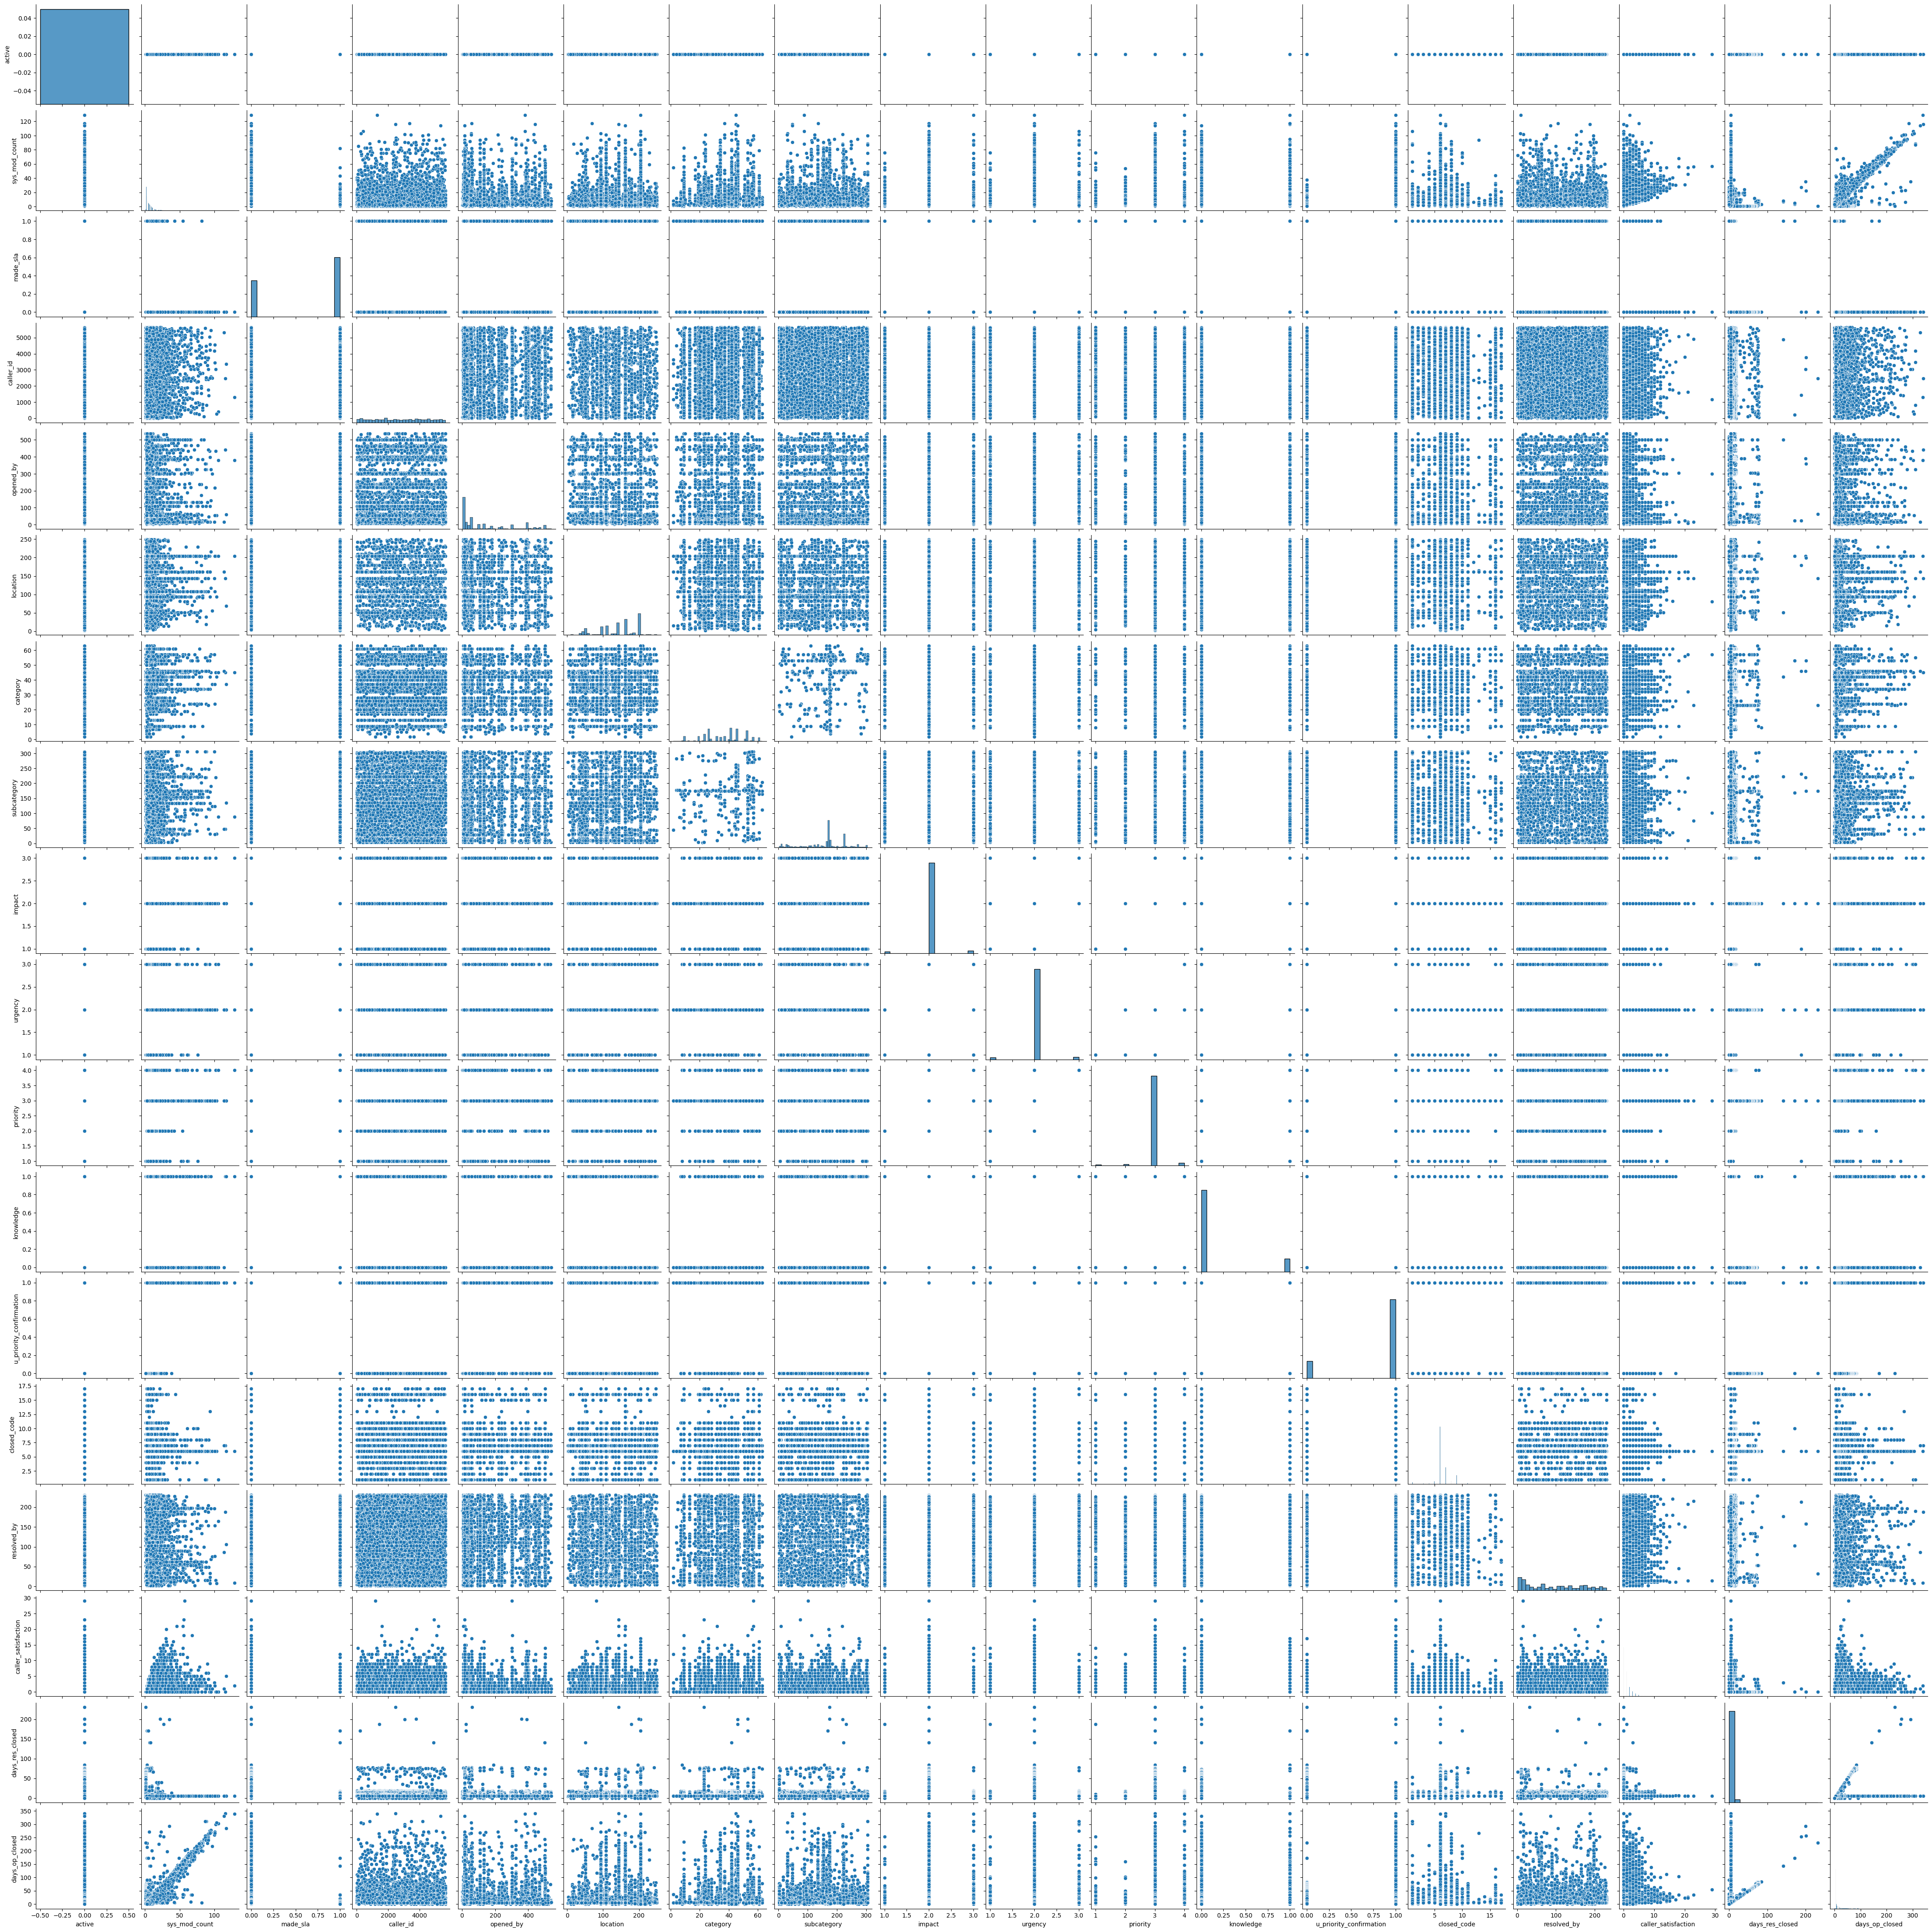

In [30]:



# Assuming df_2 is your DataFrame with features
feature_cols = df_2.columns
vector_assembler = VectorAssembler(inputCols=feature_cols, outputCol="features")
df_assembled = vector_assembler.transform(df_2)

# Convert the DataFrame to a Pandas DataFrame for easier plotting
df_pd = df_assembled.select(feature_cols).toPandas()

# Create pairwise scatter plots using Seaborn
sns.pairplot(df_pd)
plt.show()



#**PCA**

Some columns are dropped because are irrilevant with the tasks that we will perform. This is made on semantic point of view, because the ID of the person can change so it is not a kind of information that is useful.

In [31]:
columns_to_drop = ['resolved_by', 'caller_id', 'opened_by','active']

# Drop the specified columns
df_2 = df_2.drop(*columns_to_drop)

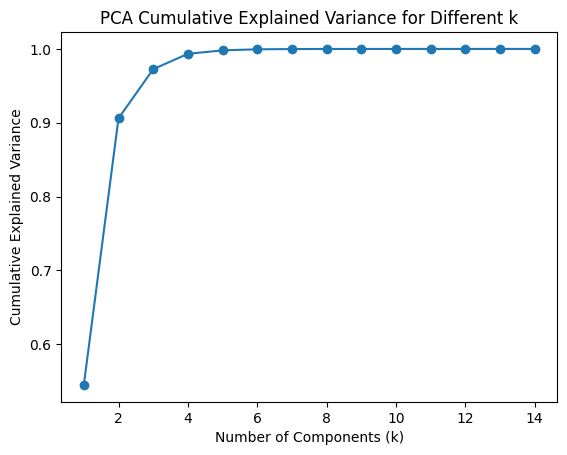

In [32]:



feature_cols = df_2.columns
vector_assembler = VectorAssembler(inputCols=feature_cols, outputCol="features")
df_assembled = vector_assembler.transform(df_2)

# Set a range of k values
k_values = range(1, len(feature_cols) + 1)

# Apply PCA for each value of k and store cumulative explained variance
cumulative_variance_ratios = []

for k in k_values:
    # Create a PCA model
    pca = PCA(k=k, inputCol="features", outputCol="pca_features")

    # Fit the model to the data
    pca_model = pca.fit(df_assembled)

    # Get the cumulative explained variance
    cumulative_variance_ratio = pca_model.explainedVariance.toArray().cumsum()[-1]
    cumulative_variance_ratios.append(cumulative_variance_ratio)

# Plot the cumulative explained variance
plt.plot(k_values, cumulative_variance_ratios, marker='o')
plt.xlabel('Number of Components (k)')
plt.ylabel('Cumulative Explained Variance')
plt.title('PCA Cumulative Explained Variance for Different k')
plt.show()

**Plot of the PCA features**

 I obtain a cumulative variance of 1 with k=4 in PCA, it means that the first four principal components capture all the variability present in my original features. In other words, these four components explain the entire variance of my dataset. This scenario can happen, and it suggests that my data may have high dimensionality, and a relatively small number of principal components is sufficient to represent the majority of the information.

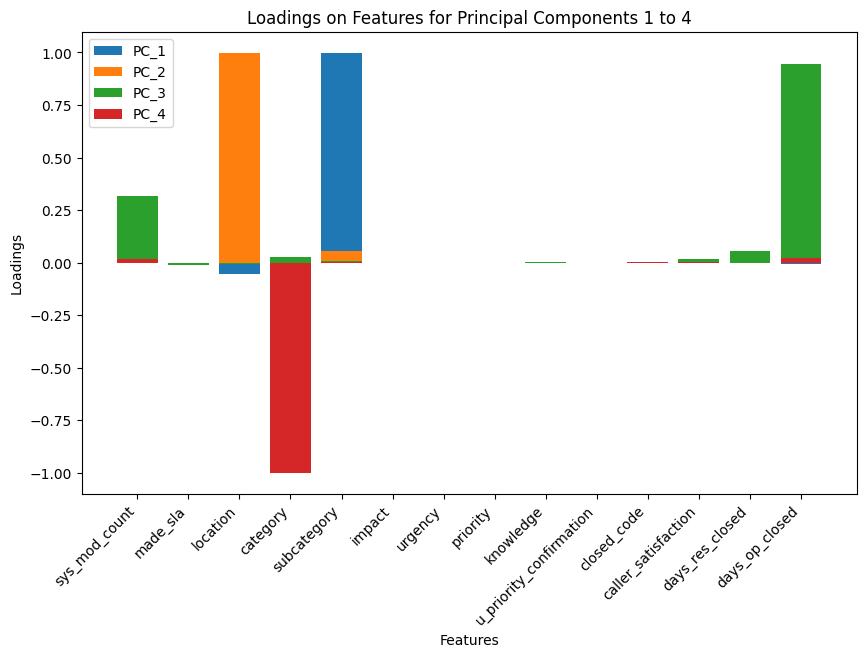

In [33]:


k=4 #better low number of Components

# Instantiate PCA model
pca = PCA(k=k, inputCol="features", outputCol="pca_features")

# Fit the PCA model
pca_model = pca.fit(df_assembled)

# Get loadings matrix
loadings_matrix = pca_model.pc.toArray()

# Extract feature names and loadings
feature_names = df_2.columns
loadings = loadings_matrix.T.tolist()

# Plotting
fig, ax = plt.subplots(figsize=(10, 6))

# Bar plot for each principal component
for i in range(k):
    ax.bar(feature_names, loadings[i], label=f'PC_{i + 1}')

# Adding labels and title
ax.set_xlabel('Features')
ax.set_ylabel('Loadings')
ax.set_title(f'Loadings on Features for Principal Components 1 to {k}')

# Rotating x-axis labels for better visibility
plt.xticks(rotation=45, ha='right')

# Adding legend
ax.legend()

# Show the plot
plt.show()


#Select the principal components

In [34]:
list_of_selected_features=['location','category','subcategory','days_op_closed'] # pca components

#**Regression**

The models for the regression to guess the days_op_closed are :  

1.   Random Forest Regressor
2.   GBTRegressor
3.   Decision Tree Regressor
4.   Linear Regressor

The models for the regression to guess the sys_mod_count are :  

1.   Random Forest Regressor
2.   Linear Regressor

The models for the regression to guess the days_res_closed are :  

1.   Random Forest Regressor
2.   Linear Regressor

The Regressors performance are evaluated on RMSE and the better is Random Forest Regressor on most of the features

**Starting from sys_mod_count, location,category and subcategory  guess the days_op_closed using Random Forest Regressor**

In [35]:
formula = " ~ sys_mod_count+location+category+subcategory"



rf = RFormula(formula=formula, featuresCol="features", labelCol="label")
rf_fit = rf.fit(df_2)
rf_transformed = rf_fit.transform(df_2)

rf_transformed.show()

rf_transformed=rf_transformed.select(['features','days_op_closed'])
rf_transformed.show()

(df_train, df_test) = rf_transformed.randomSplit([0.7, 0.3], seed=seed)
print('Number of instances in the training set:', df_train.count())
print('Number of instances in the test set:', df_test.count())

in_train = df_train.selectExpr("features", "days_op_closed as label")
in_train.show()

in_test = df_test.selectExpr("features", "days_op_closed as label")
in_test.show()

# Create a RandomForestRegressor
rf = RandomForestRegressor(featuresCol='features', labelCol='label', numTrees=10)

# Train the model
rf_model = rf.fit(in_train)

# Make predictions on the test set
predictions_test = rf_model.transform(in_test).select("label", col("prediction").alias("prediction"))
predictions_test_rounded = predictions_test.withColumn("prediction", col("prediction").cast("double"))

reg_evaluator_rmse = RegressionEvaluator(labelCol='label', predictionCol='prediction', metricName='rmse')
rmse = reg_evaluator_rmse.evaluate(predictions_test_rounded)
print(f"Root Mean Squared Error (RMSE): {rmse:.4f}")

reg_evaluator_mae = RegressionEvaluator(labelCol='label', predictionCol='prediction', metricName='mae')
mae = reg_evaluator_mae.evaluate(predictions_test_rounded)
print(f"Mean Absolute Error (MAE): {mae:.4f}")

reg_evaluator_r2 = RegressionEvaluator(labelCol='label', predictionCol='prediction', metricName='r2')
r2 = reg_evaluator_r2.evaluate(predictions_test_rounded)
print(f"R-squared (R2): {r2:.4f}")


+-------------+--------+--------+--------+-----------+------+-------+--------+---------+-----------------------+-----------+-------------------+---------------+--------------+--------------------+
|sys_mod_count|made_sla|location|category|subcategory|impact|urgency|priority|knowledge|u_priority_confirmation|closed_code|caller_satisfaction|days_res_closed|days_op_closed|            features|
+-------------+--------+--------+--------+-----------+------+-------+--------+---------+-----------------------+-----------+-------------------+---------------+--------------+--------------------+
|            4|       1|     143|      55|        170|     2|      2|       3|        1|                      0|          5|                  0|              5|             5|[4.0,143.0,55.0,1...|
|            8|       1|     165|      40|        215|     2|      2|       3|        1|                      0|          5|                  1|              5|             6|[8.0,165.0,40.0,2...|
|            6|

Prediction by GBTRegressor

In [36]:
# Create a GBT Regressor model
gbt = GBTRegressor(featuresCol='features', labelCol='label')

# Train the model
gbt_model = gbt.fit(in_train)

# Make predictions on the test set
predictions_test = gbt_model.transform(in_test).select("label", col("prediction").alias("prediction"))

predictions_test_rounded = predictions_test.withColumn("prediction", col("prediction").cast("double"))

reg_evaluator_rmse = RegressionEvaluator(labelCol='label', predictionCol='prediction', metricName='rmse')
rmse = reg_evaluator_rmse.evaluate(predictions_test_rounded)
print(f"Root Mean Squared Error (RMSE): {rmse:.4f}")

reg_evaluator_mae = RegressionEvaluator(labelCol='label', predictionCol='prediction', metricName='mae')
mae = reg_evaluator_mae.evaluate(predictions_test_rounded)
print(f"Mean Absolute Error (MAE): {mae:.4f}")

reg_evaluator_r2 = RegressionEvaluator(labelCol='label', predictionCol='prediction', metricName='r2')
r2 = reg_evaluator_r2.evaluate(predictions_test_rounded)
print(f"R-squared (R2): {r2:.4f}")


Root Mean Squared Error (RMSE): 10.9175
Mean Absolute Error (MAE): 4.7224
R-squared (R2): 0.7865


Prediction by DecisionTreeRegressor

In [37]:
# Create a Decision Tree Regressor model
dt = DecisionTreeRegressor(featuresCol='features', labelCol='label')

# Train the model
dt_model = dt.fit(in_train)

predictions_test = dt_model.transform(in_test).select("label", col("prediction").alias("prediction"))

predictions_test_rounded = predictions_test.withColumn("prediction", col("prediction").cast("double"))

reg_evaluator_rmse = RegressionEvaluator(labelCol='label', predictionCol='prediction', metricName='rmse')
rmse = reg_evaluator_rmse.evaluate(predictions_test_rounded)
print(f"Root Mean Squared Error (RMSE): {rmse:.4f}")

reg_evaluator_mae = RegressionEvaluator(labelCol='label', predictionCol='prediction', metricName='mae')
mae = reg_evaluator_mae.evaluate(predictions_test_rounded)
print(f"Mean Absolute Error (MAE): {mae:.4f}")

reg_evaluator_r2 = RegressionEvaluator(labelCol='label', predictionCol='prediction', metricName='r2')
r2 = reg_evaluator_r2.evaluate(predictions_test_rounded)
print(f"R-squared (R2): {r2:.4f}")




Root Mean Squared Error (RMSE): 11.1143
Mean Absolute Error (MAE): 5.0147
R-squared (R2): 0.7787


Prediction by LinearRegressor


In [38]:
# Create a Linear Regression model
lr = LinearRegression(featuresCol='features', labelCol='label')

# Train the model
lr_model = lr.fit(in_train)

# Make predictions
predictions_test = lr_model.transform(in_test).select("label", col("prediction").alias("prediction"))

predictions_test_rounded = predictions_test.withColumn("prediction", col("prediction").cast("double"))

reg_evaluator_rmse = RegressionEvaluator(labelCol='label', predictionCol='prediction', metricName='rmse')
rmse = reg_evaluator_rmse.evaluate(predictions_test_rounded)
print(f"Root Mean Squared Error (RMSE): {rmse:.4f}")

reg_evaluator_mae = RegressionEvaluator(labelCol='label', predictionCol='prediction', metricName='mae')
mae = reg_evaluator_mae.evaluate(predictions_test_rounded)
print(f"Mean Absolute Error (MAE): {mae:.4f}")

reg_evaluator_r2 = RegressionEvaluator(labelCol='label', predictionCol='prediction', metricName='r2')
r2 = reg_evaluator_r2.evaluate(predictions_test_rounded)
print(f"R-squared (R2): {r2:.4f}")


Root Mean Squared Error (RMSE): 10.9734
Mean Absolute Error (MAE): 5.8720
R-squared (R2): 0.7843


**Starting from days_op_closed, location, category and subcategory guess the sys_mod_count using Random Forest Regressor**

In [39]:

formula = " ~ days_op_closed+location+category+subcategory"



rf = RFormula(formula=formula, featuresCol="features", labelCol="label")
rf_fit = rf.fit(df_2)
rf_transformed = rf_fit.transform(df_2)

rf_transformed.show()

rf_transformed=rf_transformed.select(['features','sys_mod_count'])
rf_transformed.show()



(df_train, df_test) = rf_transformed.randomSplit([0.7, 0.3], seed=seed)
print('Number of instances in the training set:', df_train.count())
print('Number of instances in the test set:', df_test.count())

in_train = df_train.selectExpr("features", "sys_mod_count as label")
in_train.show()

in_test = df_test.selectExpr("features", "sys_mod_count as label")
in_test.show()


# Assuming 'label' is your target variable for regression

# Create a RandomForestRegressor
rf = RandomForestRegressor(featuresCol='features', labelCol='label', numTrees=10)

# Train the model
rf_model = rf.fit(in_train)

# Make predictions on the test set
predictions_test = rf_model.transform(in_test).select("label", col("prediction").alias("prediction"))
predictions_test_rounded = predictions_test.withColumn("prediction", col("prediction").cast("double"))


reg_evaluator_rmse = RegressionEvaluator(labelCol='label', predictionCol='prediction', metricName='rmse')
rmse = reg_evaluator_rmse.evaluate(predictions_test_rounded)
print(f"Root Mean Squared Error (RMSE): {rmse:.4f}")

reg_evaluator_mae = RegressionEvaluator(labelCol='label', predictionCol='prediction', metricName='mae')
mae = reg_evaluator_mae.evaluate(predictions_test_rounded)
print(f"Mean Absolute Error (MAE): {mae:.4f}")

reg_evaluator_r2 = RegressionEvaluator(labelCol='label', predictionCol='prediction', metricName='r2')
r2 = reg_evaluator_r2.evaluate(predictions_test_rounded)
print(f"R-squared (R2): {r2:.4f}")


+-------------+--------+--------+--------+-----------+------+-------+--------+---------+-----------------------+-----------+-------------------+---------------+--------------+--------------------+
|sys_mod_count|made_sla|location|category|subcategory|impact|urgency|priority|knowledge|u_priority_confirmation|closed_code|caller_satisfaction|days_res_closed|days_op_closed|            features|
+-------------+--------+--------+--------+-----------+------+-------+--------+---------+-----------------------+-----------+-------------------+---------------+--------------+--------------------+
|            4|       1|     143|      55|        170|     2|      2|       3|        1|                      0|          5|                  0|              5|             5|[5.0,143.0,55.0,1...|
|            8|       1|     165|      40|        215|     2|      2|       3|        1|                      0|          5|                  1|              5|             6|[6.0,165.0,40.0,2...|
|            6|

Prediction by the Linear Regressor

In [40]:
# Create a Linear Regression model
lr = LinearRegression(featuresCol='features', labelCol='label')

# Train the model
lr_model = lr.fit(in_train)

# Make predictions
predictions_test = lr_model.transform(in_test).select("label", col("prediction").alias("prediction"))

predictions_test_rounded = predictions_test.withColumn("prediction", col("prediction").cast("double"))

reg_evaluator_rmse = RegressionEvaluator(labelCol='label', predictionCol='prediction', metricName='rmse')
rmse = reg_evaluator_rmse.evaluate(predictions_test_rounded)
print(f"Root Mean Squared Error (RMSE): {rmse:.4f}")

reg_evaluator_mae = RegressionEvaluator(labelCol='label', predictionCol='prediction', metricName='mae')
mae = reg_evaluator_mae.evaluate(predictions_test_rounded)
print(f"Mean Absolute Error (MAE): {mae:.4f}")

reg_evaluator_r2 = RegressionEvaluator(labelCol='label', predictionCol='prediction', metricName='r2')
r2 = reg_evaluator_r2.evaluate(predictions_test_rounded)
print(f"R-squared (R2): {r2:.4f}")

Root Mean Squared Error (RMSE): 4.4409
Mean Absolute Error (MAE): 2.6223
R-squared (R2): 0.7471


**Starting from location, category, subcategory and days_op_closed guess the days_res_closed using Random Forest Regressor**

In [41]:
formula = " ~ location+category+subcategory+days_op_closed"



rf = RFormula(formula=formula, featuresCol="features", labelCol="label")
rf_fit = rf.fit(df_2)
rf_transformed = rf_fit.transform(df_2)

rf_transformed.show()

rf_transformed=rf_transformed.select(['features','days_res_closed'])
rf_transformed.show()



(df_train, df_test) = rf_transformed.randomSplit([0.7, 0.3], seed=seed)
print('Number of instances in the training set:', df_train.count())
print('Number of instances in the test set:', df_test.count())

in_train = df_train.selectExpr("features", "days_res_closed as label")
in_train.show()

in_test = df_test.selectExpr("features", "days_res_closed as label")
in_test.show()

# Create a RandomForestRegressor
rf = RandomForestRegressor(featuresCol='features', labelCol='label', numTrees=10)

# Train the model
rf_model = rf.fit(in_train)

# Make predictions on the test set
predictions_test = rf_model.transform(in_test).select("label", col("prediction").alias("prediction"))
predictions_test_rounded = predictions_test.withColumn("prediction", col("prediction").cast("double"))

# Evaluate the model using RMSE for accuracy
rf_evaluator = RegressionEvaluator(labelCol='label', predictionCol='prediction', metricName='rmse')
rf_rmse = rf_evaluator.evaluate(predictions_test_rounded)
print(f"Root Mean Squared Error (RMSE) on test data: {rf_rmse:.2f}")


reg_evaluator_mae = RegressionEvaluator(labelCol='label', predictionCol='prediction', metricName='mae')
mae = reg_evaluator_mae.evaluate(predictions_test_rounded)
print(f"Mean Absolute Error (MAE): {mae:.4f}")

reg_evaluator_r2 = RegressionEvaluator(labelCol='label', predictionCol='prediction', metricName='r2')
r2 = reg_evaluator_r2.evaluate(predictions_test_rounded)
print(f"R-squared (R2): {r2:.4f}")

+-------------+--------+--------+--------+-----------+------+-------+--------+---------+-----------------------+-----------+-------------------+---------------+--------------+--------------------+
|sys_mod_count|made_sla|location|category|subcategory|impact|urgency|priority|knowledge|u_priority_confirmation|closed_code|caller_satisfaction|days_res_closed|days_op_closed|            features|
+-------------+--------+--------+--------+-----------+------+-------+--------+---------+-----------------------+-----------+-------------------+---------------+--------------+--------------------+
|            4|       1|     143|      55|        170|     2|      2|       3|        1|                      0|          5|                  0|              5|             5|[143.0,55.0,170.0...|
|            8|       1|     165|      40|        215|     2|      2|       3|        1|                      0|          5|                  1|              5|             6|[165.0,40.0,215.0...|
|            6|

Prediction by the Linear Regressor

In [42]:
# Create a Linear Regression model
lr = LinearRegression(featuresCol='features', labelCol='label')

# Train the model
lr_model = lr.fit(in_train)

# Make predictions
predictions_test = lr_model.transform(in_test).select("label", col("prediction").alias("prediction"))

predictions_test_rounded = predictions_test.withColumn("prediction", col("prediction").cast("double"))

reg_evaluator_rmse = RegressionEvaluator(labelCol='label', predictionCol='prediction', metricName='rmse')
rmse = reg_evaluator_rmse.evaluate(predictions_test_rounded)
print(f"Root Mean Squared Error (RMSE): {rmse:.4f}")

reg_evaluator_mae = RegressionEvaluator(labelCol='label', predictionCol='prediction', metricName='mae')
mae = reg_evaluator_mae.evaluate(predictions_test_rounded)
print(f"Mean Absolute Error (MAE): {mae:.4f}")

reg_evaluator_r2 = RegressionEvaluator(labelCol='label', predictionCol='prediction', metricName='r2')
r2 = reg_evaluator_r2.evaluate(predictions_test_rounded)
print(f"R-squared (R2): {r2:.4f}")

Root Mean Squared Error (RMSE): 5.7732
Mean Absolute Error (MAE): 1.9237
R-squared (R2): 0.0580


#**Classification**

The models for the classification to guess the caller_satisfaction are :  

1.   Random Forest Classifier
2.   Decision Tree

The models for the classification to guess the sys_mod_count are :  

1.   Random Forest Classifier
2.   Decision Tree Classifier

The models for the classification to guess the days_res_closed are :  

1.   Random Forest Classifier
2.   Decision Tree Classifier

The models for the classification to guess the priority are :  

1.   Random Forest Classifier
2.   Decision Tree Classifier

In terms of the accuracy and AUC the value of the 2 models are strictly comparable most cases with high performances

**Starting from location, category, subcategory and days_op_closed guess the caller_satisfaction using Random Forest Classifier**

In [43]:
formula = " ~ location+category+subcategory+days_op_closed"



rf = RFormula(formula=formula, featuresCol="features", labelCol="label")
rf_fit = rf.fit(df_2)
rf_transformed = rf_fit.transform(df_2)

rf_transformed.show()

rf_transformed=rf_transformed.select(['features','caller_satisfaction'])
rf_transformed.show()



(df_train, df_test) = rf_transformed.randomSplit([0.7, 0.3], seed=seed)
print('Number of instances in the training set:', df_train.count())
print('Number of instances in the test set:', df_test.count())

in_train = df_train.selectExpr("features", "caller_satisfaction as label")
in_train.show()

in_test = df_test.selectExpr("features", "caller_satisfaction as label")
in_test.show()
#-----------
rf = RandomForestClassifier()
rf_model = rf.fit(in_train)
rf_model.transform(in_train).select("label","prediction").show()
rf_pred = rf_model.transform(in_test).select("label","prediction")
rf_pred.show()
rf_evaluator = MulticlassClassificationEvaluator(labelCol='label', predictionCol='prediction', metricName='accuracy')
rf_accuracy = rf_evaluator.evaluate(rf_pred) * 100
print(f"Test accuracy: {rf_accuracy:.2f}%")

# # Evaluate precision, recall, and F1 score
rf_evaluator_binary = BinaryClassificationEvaluator(labelCol='label', rawPredictionCol='prediction', metricName='areaUnderROC')
rf_auc = rf_evaluator_binary.evaluate(rf_pred)
print(f"Area under ROC curve: {rf_auc:.4f}")

rf_evaluator_multi = MulticlassClassificationEvaluator(labelCol='label', predictionCol='prediction',metricName='weightedPrecision')
precision = rf_evaluator_multi.evaluate(rf_pred)
print(f"Weighted Precision: {precision:.4f}")

rf_evaluator_multi = MulticlassClassificationEvaluator(labelCol='label', predictionCol='prediction', metricName='weightedRecall')
recall = rf_evaluator_multi.evaluate(rf_pred)
print(f"Weighted Recall: {recall:.4f}")

rf_evaluator_multi = MulticlassClassificationEvaluator(labelCol='label', predictionCol='prediction', metricName='f1')
f1 = rf_evaluator_multi.evaluate(rf_pred)
print(f"F1 Score: {f1:.4f}")


+-------------+--------+--------+--------+-----------+------+-------+--------+---------+-----------------------+-----------+-------------------+---------------+--------------+--------------------+
|sys_mod_count|made_sla|location|category|subcategory|impact|urgency|priority|knowledge|u_priority_confirmation|closed_code|caller_satisfaction|days_res_closed|days_op_closed|            features|
+-------------+--------+--------+--------+-----------+------+-------+--------+---------+-----------------------+-----------+-------------------+---------------+--------------+--------------------+
|            4|       1|     143|      55|        170|     2|      2|       3|        1|                      0|          5|                  0|              5|             5|[143.0,55.0,170.0...|
|            8|       1|     165|      40|        215|     2|      2|       3|        1|                      0|          5|                  1|              5|             6|[165.0,40.0,215.0...|
|            6|

Prediction by the Decision Tree Classifier

In [44]:
# Instantiate and train the Decision Tree model
dt = DecisionTreeClassifier()
dt_model = dt.fit(in_train)

# Make predictions on the training set
dt_pred_train = dt_model.transform(in_train).select("label", "prediction")
dt_pred_train.show()

# Make predictions on the test set
dt_pred_test = dt_model.transform(in_test).select("label", "prediction")
dt_pred_test.show()

# Evaluate the model on accuracy
dt_evaluator = MulticlassClassificationEvaluator(labelCol='label', predictionCol='prediction', metricName='accuracy')
dt_accuracy = dt_evaluator.evaluate(dt_pred_test) * 100
print(f"Test accuracy: {dt_accuracy:.2f}%")

# Evaluate precision, recall, and F1 score
dt_evaluator_binary = BinaryClassificationEvaluator(labelCol='label', rawPredictionCol='prediction', metricName='areaUnderROC')
dt_auc = dt_evaluator_binary.evaluate(dt_pred_test)
print(f"Area under ROC curve: {dt_auc:.4f}")

dt_evaluator_multi = MulticlassClassificationEvaluator(labelCol='label', predictionCol='prediction', metricName='weightedPrecision')
precision = dt_evaluator_multi.evaluate(dt_pred_test)
print(f"Weighted Precision: {precision:.4f}")

dt_evaluator_multi = MulticlassClassificationEvaluator(labelCol='label', predictionCol='prediction', metricName='weightedRecall')
recall = dt_evaluator_multi.evaluate(dt_pred_test)
print(f"Weighted Recall: {recall:.4f}")

dt_evaluator_multi = MulticlassClassificationEvaluator(labelCol='label', predictionCol='prediction', metricName='f1')
f1 = dt_evaluator_multi.evaluate(dt_pred_test)
print(f"F1 Score: {f1:.4f}")

+-----+----------+
|label|prediction|
+-----+----------+
|    0|       1.0|
|    0|       0.0|
|    0|       0.0|
|    0|       0.0|
|    0|       0.0|
|    0|       0.0|
|    5|       1.0|
|    0|       0.0|
|    0|       0.0|
|    1|       0.0|
|    0|       0.0|
|    0|       1.0|
|    0|       0.0|
|    1|       1.0|
|    2|       1.0|
|    0|       0.0|
|    2|       0.0|
|    3|       1.0|
|    0|       0.0|
|    0|       0.0|
+-----+----------+
only showing top 20 rows

+-----+----------+
|label|prediction|
+-----+----------+
|    1|       0.0|
|    6|       1.0|
|    0|       0.0|
|    1|       1.0|
|    1|       1.0|
|    0|       0.0|
|    1|       0.0|
|    1|       1.0|
|    1|       0.0|
|    0|       0.0|
|    1|       1.0|
|    1|       1.0|
|    0|       1.0|
|    1|       1.0|
|    7|       1.0|
|    6|       1.0|
|    0|       0.0|
|    5|       1.0|
|    0|       1.0|
|    1|       1.0|
+-----+----------+
only showing top 20 rows

Test accuracy: 57.04%
Area under ROC

**Starting from location, category, subcategory and days_op_closed guess the made_sla using Random Forest Classifier**

In [45]:
formula = " ~ location+category+subcategory+days_op_closed"



rf = RFormula(formula=formula, featuresCol="features", labelCol="label")
rf_fit = rf.fit(df_2)
rf_transformed = rf_fit.transform(df_2)

rf_transformed.show()

rf_transformed=rf_transformed.select(['features','made_sla'])
rf_transformed.show()



(df_train, df_test) = rf_transformed.randomSplit([0.7, 0.3], seed=seed)
print('Number of instances in the training set:', df_train.count())
print('Number of instances in the test set:', df_test.count())

in_train = df_train.selectExpr("features", "made_sla as label")
in_train.show()

in_test = df_test.selectExpr("features", "made_sla as label")
in_test.show()
#-----------
rf = RandomForestClassifier()
rf_model = rf.fit(in_train)
rf_model.transform(in_train).select("label","prediction").show()
rf_pred = rf_model.transform(in_test).select("label","prediction")
rf_pred.show()
rf_evaluator = MulticlassClassificationEvaluator(labelCol='label', predictionCol='prediction', metricName='accuracy')
rf_accuracy = rf_evaluator.evaluate(rf_pred) * 100
print(f"Test accuracy: {rf_accuracy:.2f}%")

# # Evaluate precision, recall, and F1 score
rf_evaluator_binary = BinaryClassificationEvaluator(labelCol='label', rawPredictionCol='prediction', metricName='areaUnderROC')
rf_auc = rf_evaluator_binary.evaluate(rf_pred)
print(f"Area under ROC curve: {rf_auc:.4f}")

rf_evaluator_multi = MulticlassClassificationEvaluator(labelCol='label', predictionCol='prediction',metricName='weightedPrecision')
precision = rf_evaluator_multi.evaluate(rf_pred)
print(f"Weighted Precision: {precision:.4f}")

rf_evaluator_multi = MulticlassClassificationEvaluator(labelCol='label', predictionCol='prediction', metricName='weightedRecall')
recall = rf_evaluator_multi.evaluate(rf_pred)
print(f"Weighted Recall: {recall:.4f}")

rf_evaluator_multi = MulticlassClassificationEvaluator(labelCol='label', predictionCol='prediction', metricName='f1')
f1 = rf_evaluator_multi.evaluate(rf_pred)
print(f"F1 Score: {f1:.4f}")

+-------------+--------+--------+--------+-----------+------+-------+--------+---------+-----------------------+-----------+-------------------+---------------+--------------+--------------------+
|sys_mod_count|made_sla|location|category|subcategory|impact|urgency|priority|knowledge|u_priority_confirmation|closed_code|caller_satisfaction|days_res_closed|days_op_closed|            features|
+-------------+--------+--------+--------+-----------+------+-------+--------+---------+-----------------------+-----------+-------------------+---------------+--------------+--------------------+
|            4|       1|     143|      55|        170|     2|      2|       3|        1|                      0|          5|                  0|              5|             5|[143.0,55.0,170.0...|
|            8|       1|     165|      40|        215|     2|      2|       3|        1|                      0|          5|                  1|              5|             6|[165.0,40.0,215.0...|
|            6|

Prediction by the Decision Tree Classifier

In [46]:
# Instantiate and train the Decision Tree model
dt = DecisionTreeClassifier()
dt_model = dt.fit(in_train)

# Make predictions on the training set
dt_pred_train = dt_model.transform(in_train).select("label", "prediction")
dt_pred_train.show()

# Make predictions on the test set
dt_pred_test = dt_model.transform(in_test).select("label", "prediction")
dt_pred_test.show()

# Evaluate the model on accuracy
dt_evaluator = MulticlassClassificationEvaluator(labelCol='label', predictionCol='prediction', metricName='accuracy')
dt_accuracy = dt_evaluator.evaluate(dt_pred_test) * 100
print(f"Test accuracy: {dt_accuracy:.2f}%")

# Evaluate precision, recall, and F1 score
dt_evaluator_binary = BinaryClassificationEvaluator(labelCol='label', rawPredictionCol='prediction', metricName='areaUnderROC')
dt_auc = dt_evaluator_binary.evaluate(dt_pred_test)
print(f"Area under ROC curve: {dt_auc:.4f}")

dt_evaluator_multi = MulticlassClassificationEvaluator(labelCol='label', predictionCol='prediction', metricName='weightedPrecision')
precision = dt_evaluator_multi.evaluate(dt_pred_test)
print(f"Weighted Precision: {precision:.4f}")

dt_evaluator_multi = MulticlassClassificationEvaluator(labelCol='label', predictionCol='prediction', metricName='weightedRecall')
recall = dt_evaluator_multi.evaluate(dt_pred_test)
print(f"Weighted Recall: {recall:.4f}")

dt_evaluator_multi = MulticlassClassificationEvaluator(labelCol='label', predictionCol='prediction', metricName='f1')
f1 = dt_evaluator_multi.evaluate(dt_pred_test)
print(f"F1 Score: {f1:.4f}")

+-----+----------+
|label|prediction|
+-----+----------+
|    1|       1.0|
|    1|       1.0|
|    1|       1.0|
|    0|       0.0|
|    1|       1.0|
|    1|       1.0|
|    1|       0.0|
|    1|       1.0|
|    1|       1.0|
|    0|       0.0|
|    1|       1.0|
|    1|       1.0|
|    1|       0.0|
|    0|       0.0|
|    0|       0.0|
|    1|       1.0|
|    1|       1.0|
|    1|       1.0|
|    1|       1.0|
|    0|       0.0|
+-----+----------+
only showing top 20 rows

+-----+----------+
|label|prediction|
+-----+----------+
|    0|       0.0|
|    1|       0.0|
|    1|       1.0|
|    0|       0.0|
|    1|       1.0|
|    1|       1.0|
|    0|       0.0|
|    1|       0.0|
|    1|       1.0|
|    0|       0.0|
|    0|       0.0|
|    1|       1.0|
|    1|       1.0|
|    0|       0.0|
|    0|       0.0|
|    0|       0.0|
|    1|       1.0|
|    0|       0.0|
|    0|       0.0|
|    1|       1.0|
+-----+----------+
only showing top 20 rows

Test accuracy: 95.64%
Area under ROC

**Starting from location, category, subcategory and days_op_closed guess the urgency using Random Forest Classifier**

In [47]:
formula = " ~ location+category+subcategory+days_op_closed"



rf = RFormula(formula=formula, featuresCol="features", labelCol="label")
rf_fit = rf.fit(df_2)
rf_transformed = rf_fit.transform(df_2)

rf_transformed.show()

rf_transformed=rf_transformed.select(['features','urgency'])
rf_transformed.show()



(df_train, df_test) = rf_transformed.randomSplit([0.7, 0.3], seed=seed)
print('Number of instances in the training set:', df_train.count())
print('Number of instances in the test set:', df_test.count())

in_train = df_train.selectExpr("features", "urgency as label")
in_train.show()

in_test = df_test.selectExpr("features", "urgency as label")
in_test.show()
rf = RandomForestClassifier()
rf_model = rf.fit(in_train)
rf_model.transform(in_train).select("label","prediction").show()
rf_pred = rf_model.transform(in_test).select("label","prediction")
rf_pred.show()
rf_evaluator = MulticlassClassificationEvaluator(labelCol='label', predictionCol='prediction', metricName='accuracy')
rf_accuracy = rf_evaluator.evaluate(rf_pred) * 100
print(f"Test accuracy: {rf_accuracy:.2f}%")
# # Evaluate precision, recall, and F1 score
rf_evaluator_binary = BinaryClassificationEvaluator(labelCol='label', rawPredictionCol='prediction', metricName='areaUnderROC')
rf_auc = rf_evaluator_binary.evaluate(rf_pred)
print(f"Area under ROC curve: {rf_auc:.4f}")

rf_evaluator_multi = MulticlassClassificationEvaluator(labelCol='label', predictionCol='prediction',metricName='weightedPrecision')
precision = rf_evaluator_multi.evaluate(rf_pred)
print(f"Weighted Precision: {precision:.4f}")

rf_evaluator_multi = MulticlassClassificationEvaluator(labelCol='label', predictionCol='prediction', metricName='weightedRecall')
recall = rf_evaluator_multi.evaluate(rf_pred)
print(f"Weighted Recall: {recall:.4f}")

rf_evaluator_multi = MulticlassClassificationEvaluator(labelCol='label', predictionCol='prediction', metricName='f1')
f1 = rf_evaluator_multi.evaluate(rf_pred)
print(f"F1 Score: {f1:.4f}")

+-------------+--------+--------+--------+-----------+------+-------+--------+---------+-----------------------+-----------+-------------------+---------------+--------------+--------------------+
|sys_mod_count|made_sla|location|category|subcategory|impact|urgency|priority|knowledge|u_priority_confirmation|closed_code|caller_satisfaction|days_res_closed|days_op_closed|            features|
+-------------+--------+--------+--------+-----------+------+-------+--------+---------+-----------------------+-----------+-------------------+---------------+--------------+--------------------+
|            4|       1|     143|      55|        170|     2|      2|       3|        1|                      0|          5|                  0|              5|             5|[143.0,55.0,170.0...|
|            8|       1|     165|      40|        215|     2|      2|       3|        1|                      0|          5|                  1|              5|             6|[165.0,40.0,215.0...|
|            6|

Prediction by the Decision Tree Classifier

In [48]:
# Instantiate and train the Decision Tree model
dt = DecisionTreeClassifier()
dt_model = dt.fit(in_train)

# Make predictions on the training set
dt_pred_train = dt_model.transform(in_train).select("label", "prediction")
dt_pred_train.show()

# Make predictions on the test set
dt_pred_test = dt_model.transform(in_test).select("label", "prediction")
dt_pred_test.show()

# Evaluate the model on accuracy
dt_evaluator = MulticlassClassificationEvaluator(labelCol='label', predictionCol='prediction', metricName='accuracy')
dt_accuracy = dt_evaluator.evaluate(dt_pred_test) * 100
print(f"Test accuracy: {dt_accuracy:.2f}%")

# Evaluate precision, recall, and F1 score
dt_evaluator_binary = BinaryClassificationEvaluator(labelCol='label', rawPredictionCol='prediction', metricName='areaUnderROC')
dt_auc = dt_evaluator_binary.evaluate(dt_pred_test)
print(f"Area under ROC curve: {dt_auc:.4f}")

dt_evaluator_multi = MulticlassClassificationEvaluator(labelCol='label', predictionCol='prediction', metricName='weightedPrecision')
precision = dt_evaluator_multi.evaluate(dt_pred_test)
print(f"Weighted Precision: {precision:.4f}")

dt_evaluator_multi = MulticlassClassificationEvaluator(labelCol='label', predictionCol='prediction', metricName='weightedRecall')
recall = dt_evaluator_multi.evaluate(dt_pred_test)
print(f"Weighted Recall: {recall:.4f}")

dt_evaluator_multi = MulticlassClassificationEvaluator(labelCol='label', predictionCol='prediction', metricName='f1')
f1 = dt_evaluator_multi.evaluate(dt_pred_test)
print(f"F1 Score: {f1:.4f}")

+-----+----------+
|label|prediction|
+-----+----------+
|    2|       2.0|
|    2|       2.0|
|    2|       2.0|
|    2|       2.0|
|    2|       2.0|
|    2|       2.0|
|    2|       2.0|
|    2|       2.0|
|    2|       2.0|
|    2|       2.0|
|    2|       2.0|
|    2|       2.0|
|    3|       2.0|
|    2|       2.0|
|    2|       2.0|
|    2|       2.0|
|    2|       2.0|
|    2|       2.0|
|    2|       2.0|
|    2|       2.0|
+-----+----------+
only showing top 20 rows

+-----+----------+
|label|prediction|
+-----+----------+
|    2|       2.0|
|    2|       2.0|
|    2|       2.0|
|    2|       2.0|
|    2|       2.0|
|    2|       2.0|
|    2|       2.0|
|    2|       2.0|
|    1|       1.0|
|    2|       2.0|
|    2|       2.0|
|    2|       2.0|
|    2|       2.0|
|    2|       2.0|
|    2|       2.0|
|    2|       2.0|
|    2|       2.0|
|    2|       2.0|
|    2|       2.0|
|    2|       2.0|
+-----+----------+
only showing top 20 rows

Test accuracy: 95.46%
Area under ROC

**Starting from location, category, subcategory and days_op_closed guess the priority using Random Forest Classifier**

In [49]:
formula = " ~ location+category+subcategory+days_op_closed"



rf = RFormula(formula=formula, featuresCol="features", labelCol="label")
rf_fit = rf.fit(df_2)
rf_transformed = rf_fit.transform(df_2)

rf_transformed.show()

rf_transformed=rf_transformed.select(['features','urgency'])
rf_transformed.show()



(df_train, df_test) = rf_transformed.randomSplit([0.7, 0.3], seed=seed)
print('Number of instances in the training set:', df_train.count())
print('Number of instances in the test set:', df_test.count())

in_train = df_train.selectExpr("features", "urgency as label")
in_train.show()

in_test = df_test.selectExpr("features", "urgency as label")
in_test.show()
#-----------
rf = RandomForestClassifier()
rf_model = rf.fit(in_train)
rf_model.transform(in_train).select("label","prediction").show()
rf_pred = rf_model.transform(in_test).select("label","prediction")
rf_pred.show()
rf_evaluator = MulticlassClassificationEvaluator(labelCol='label', predictionCol='prediction', metricName='accuracy')
rf_accuracy = rf_evaluator.evaluate(rf_pred) * 100
print(f"Test accuracy: {rf_accuracy:.2f}%")
# # Evaluate precision, recall, and F1 score
rf_evaluator_binary = BinaryClassificationEvaluator(labelCol='label', rawPredictionCol='prediction', metricName='areaUnderROC')
rf_auc = rf_evaluator_binary.evaluate(rf_pred)
print(f"Area under ROC curve: {rf_auc:.4f}")

rf_evaluator_multi = MulticlassClassificationEvaluator(labelCol='label', predictionCol='prediction',metricName='weightedPrecision')
precision = rf_evaluator_multi.evaluate(rf_pred)
print(f"Weighted Precision: {precision:.4f}")

rf_evaluator_multi = MulticlassClassificationEvaluator(labelCol='label', predictionCol='prediction', metricName='weightedRecall')
recall = rf_evaluator_multi.evaluate(rf_pred)
print(f"Weighted Recall: {recall:.4f}")

rf_evaluator_multi = MulticlassClassificationEvaluator(labelCol='label', predictionCol='prediction', metricName='f1')
f1 = rf_evaluator_multi.evaluate(rf_pred)
print(f"F1 Score: {f1:.4f}")

+-------------+--------+--------+--------+-----------+------+-------+--------+---------+-----------------------+-----------+-------------------+---------------+--------------+--------------------+
|sys_mod_count|made_sla|location|category|subcategory|impact|urgency|priority|knowledge|u_priority_confirmation|closed_code|caller_satisfaction|days_res_closed|days_op_closed|            features|
+-------------+--------+--------+--------+-----------+------+-------+--------+---------+-----------------------+-----------+-------------------+---------------+--------------+--------------------+
|            4|       1|     143|      55|        170|     2|      2|       3|        1|                      0|          5|                  0|              5|             5|[143.0,55.0,170.0...|
|            8|       1|     165|      40|        215|     2|      2|       3|        1|                      0|          5|                  1|              5|             6|[165.0,40.0,215.0...|
|            6|

Prediction by the Decision Tree Classifier

In [50]:
# Instantiate and train the Decision Tree model
dt = DecisionTreeClassifier()
dt_model = dt.fit(in_train)

# Make predictions on the training set
dt_pred_train = dt_model.transform(in_train).select("label", "prediction")
dt_pred_train.show()

# Make predictions on the test set
dt_pred_test = dt_model.transform(in_test).select("label", "prediction")
dt_pred_test.show()

# Evaluate the model on accuracy
dt_evaluator = MulticlassClassificationEvaluator(labelCol='label', predictionCol='prediction', metricName='accuracy')
dt_accuracy = dt_evaluator.evaluate(dt_pred_test) * 100
print(f"Test accuracy: {dt_accuracy:.2f}%")

# Evaluate precision, recall, and F1 score
dt_evaluator_binary = BinaryClassificationEvaluator(labelCol='label', rawPredictionCol='prediction', metricName='areaUnderROC')
dt_auc = dt_evaluator_binary.evaluate(dt_pred_test)
print(f"Area under ROC curve: {dt_auc:.4f}")

dt_evaluator_multi = MulticlassClassificationEvaluator(labelCol='label', predictionCol='prediction', metricName='weightedPrecision')
precision = dt_evaluator_multi.evaluate(dt_pred_test)
print(f"Weighted Precision: {precision:.4f}")

dt_evaluator_multi = MulticlassClassificationEvaluator(labelCol='label', predictionCol='prediction', metricName='weightedRecall')
recall = dt_evaluator_multi.evaluate(dt_pred_test)
print(f"Weighted Recall: {recall:.4f}")

dt_evaluator_multi = MulticlassClassificationEvaluator(labelCol='label', predictionCol='prediction', metricName='f1')
f1 = dt_evaluator_multi.evaluate(dt_pred_test)
print(f"F1 Score: {f1:.4f}")

+-----+----------+
|label|prediction|
+-----+----------+
|    2|       2.0|
|    2|       2.0|
|    2|       2.0|
|    2|       2.0|
|    2|       2.0|
|    2|       2.0|
|    2|       2.0|
|    2|       2.0|
|    2|       2.0|
|    2|       2.0|
|    2|       2.0|
|    2|       2.0|
|    3|       2.0|
|    2|       2.0|
|    2|       2.0|
|    2|       2.0|
|    2|       2.0|
|    2|       2.0|
|    2|       2.0|
|    2|       2.0|
+-----+----------+
only showing top 20 rows

+-----+----------+
|label|prediction|
+-----+----------+
|    2|       2.0|
|    2|       2.0|
|    2|       2.0|
|    2|       2.0|
|    2|       2.0|
|    2|       2.0|
|    2|       2.0|
|    2|       2.0|
|    1|       1.0|
|    2|       2.0|
|    2|       2.0|
|    2|       2.0|
|    2|       2.0|
|    2|       2.0|
|    2|       2.0|
|    2|       2.0|
|    2|       2.0|
|    2|       2.0|
|    2|       2.0|
|    2|       2.0|
+-----+----------+
only showing top 20 rows

Test accuracy: 95.46%
Area under ROC

#**Clustering**

In the realm of clustering, it is vital to standardize features to guarantee they possess comparable ranges. This standardization is imperative to prevent any single feature from disproportionately influencing distance calculations, particularly in clustering algorithms like k-means. The StandardScaler, a widely adopted method for feature standardization, proves valuable in this context.

The StandardScaler in PySpark serves as a data preprocessing tool, transforming dataset features by subtracting their mean and dividing by their standard deviation. This transformation not only centers the data around zero but also scales it to achieve unit variance. Consequently, this process ensures that all features share a similar scale. The balanced scale guarantees that no single feature unduly impacts the clustering procedure, fostering unbiased and reliable results.

To sum up, incorporating the StandardScaler in PySpark is an indispensable measure. It normalizes features, fostering comparability and mitigating biased clustering outcomes stemming from variations in feature magnitudes.

+-------------+--------+--------+--------+-----------+------+-------+--------+---------+-----------------------+-----------+-------------------+---------------+--------------+--------------------+
|sys_mod_count|made_sla|location|category|subcategory|impact|urgency|priority|knowledge|u_priority_confirmation|closed_code|caller_satisfaction|days_res_closed|days_op_closed|            features|
+-------------+--------+--------+--------+-----------+------+-------+--------+---------+-----------------------+-----------+-------------------+---------------+--------------+--------------------+
|            4|       1|     143|      55|        170|     2|      2|       3|        1|                      0|          5|                  0|              5|             5|[143.0,55.0,170.0...|
|            8|       1|     165|      40|        215|     2|      2|       3|        1|                      0|          5|                  1|              5|             6|[165.0,40.0,215.0...|
|            6|

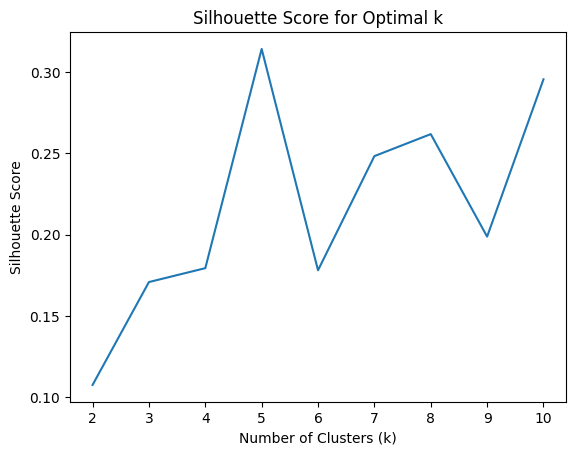

+--------+--------+-----------+--------------+
|location|category|subcategory|days_op_closed|
+--------+--------+-----------+--------------+
|     143|      55|        170|             5|
|     165|      40|        215|             6|
|     204|      20|        125|             6|
|     204|       9|         97|             7|
|      93|      53|        168|             5|
|      93|      20|        125|             5|
|     143|      53|        168|             8|
|     108|      45|         94|             7|
|     161|      55|        185|             7|
|     143|       9|        110|             7|
|      46|       9|        164|            24|
|     161|       9|        164|             6|
|      42|      53|        271|             6|
|     204|      45|        220|            47|
|      93|      42|        224|             5|
|     108|      32|          9|             5|
|     204|      55|        170|             5|
|     229|      32|          9|             7|
|      93|   

In [51]:
formula = " ~ location+category+subcategory+days_op_closed"



rf = RFormula(formula=formula, featuresCol="features", labelCol="label")
rf_fit = rf.fit(df_2)
rf_transformed = rf_fit.transform(df_2)

rf_transformed.show()

scaler = StandardScaler(inputCol="features", outputCol="scaledFeatures")
rf_transformed = scaler.fit(rf_transformed).transform(rf_transformed)
rf_transformed.show()
#Clustering
silhouette_scores = []
for k in range(2, 11):
    kmeans = KMeans(featuresCol="scaledFeatures", k=k, seed=seed)
    model = kmeans.fit(rf_transformed)
    clusters = model.transform(rf_transformed)
    evaluator = ClusteringEvaluator()
    silhouette_score = evaluator.evaluate(clusters)
    silhouette_scores.append(silhouette_score)

# Plot the silhouette scores for different k
plt.plot(range(2, 11), silhouette_scores)
plt.xlabel("Number of Clusters (k)")
plt.ylabel("Silhouette Score")
plt.title("Silhouette Score for Optimal k")
plt.show()

k = silhouette_scores.index(np.max(silhouette_scores)) + 2

kmeans = KMeans(featuresCol="scaledFeatures", k=k, seed=seed)
kmeans_model = kmeans.fit(rf_transformed)
clusters = kmeans_model.transform(rf_transformed)
clusters.select("location", "category","subcategory", "days_op_closed").show()

df_cluster = clusters.select("location", "category","subcategory", "days_op_closed").toPandas()  # convert to Pandas DataFrame


Best value of k according the silhoutte score is:

In [52]:
k

5

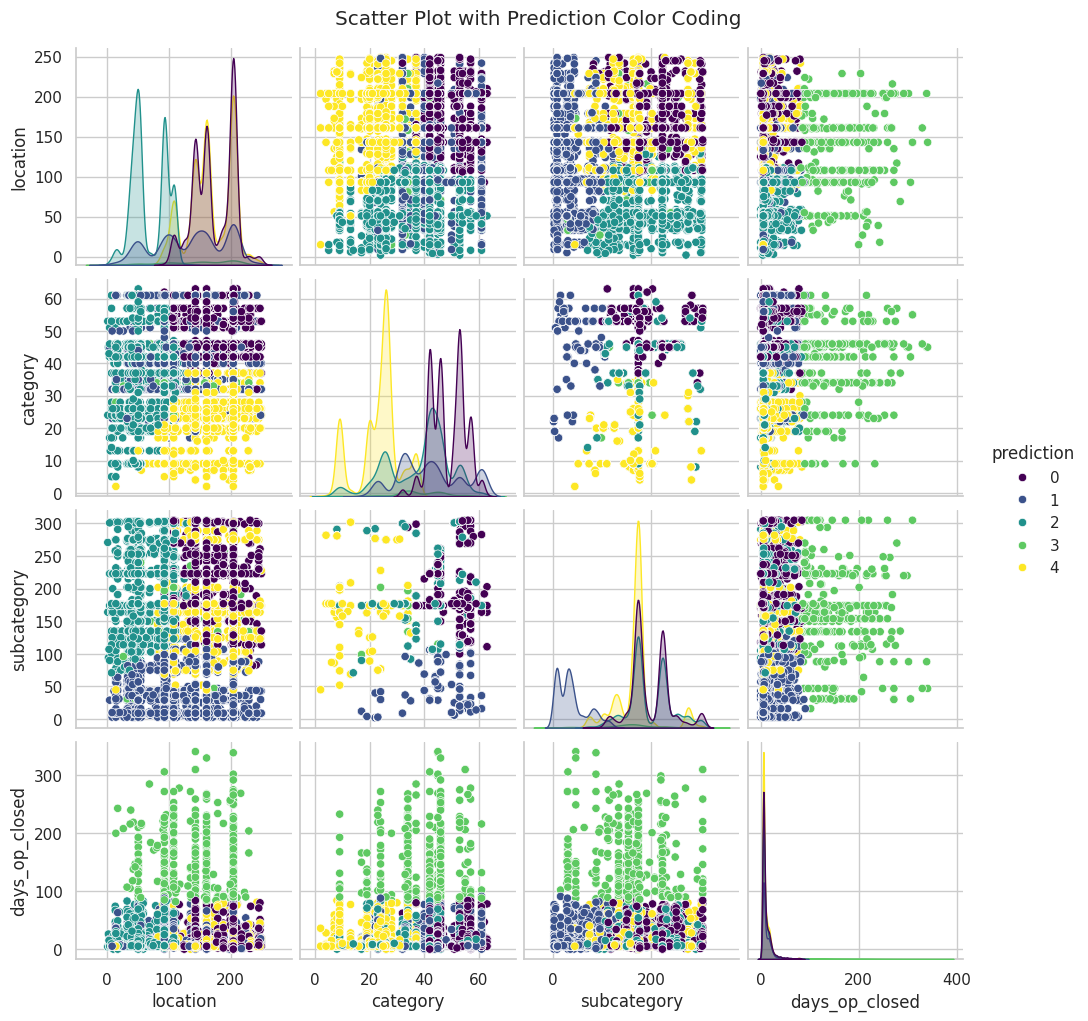

In [53]:

# Assuming you have a Spark session named 'spark'
spark = SparkSession.builder.appName("scatter_plot").getOrCreate()

# Assuming 'clusters' is your PySpark DataFrame
pandas_df = clusters.select("location", "category", "subcategory", "days_op_closed", "prediction").toPandas()

# Scatter plot using seaborn with color-coded 'prediction'
sns.set(style="whitegrid")
scatter_plot = sns.pairplot(pandas_df, hue="prediction", palette="viridis", height=2.5)
scatter_plot.fig.suptitle("Scatter Plot with Prediction Color Coding", y=1.02)
plt.show()
